# Fine-tuning a Pretrained Network for Style Recognition

In this example, we'll explore a common approach that is particularly useful in real-world applications: take a pre-trained Caffe network and fine-tune the parameters on your custom data.

The advantage of this approach is that, since pre-trained networks are learned on a large set of images, the intermediate layers capture the "semantics" of the general visual appearance. Think of it as a very powerful generic visual feature that you can treat as a black box. On top of that, only a relatively small amount of data is needed for good performance on the target task.

First, we will need to prepare the data. This involves the following parts:
(1) Get the ImageNet ilsvrc pretrained model with the provided shell scripts.
(2) Download a subset of the overall Flickr style dataset for this demo.
(3) Compile the downloaded Flickr dataset into a database that Caffe can then consume.

In [1]:
import os
os.chdir('..')
import sys
sys.path.insert(0, './python')
import tempfile

import caffe
caffe.set_mode_gpu()
caffe.set_device(0)
import numpy as np
from pylab import *
%matplotlib inline

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [2]:
# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet
!python examples/finetune_flickr_style/assemble_data.py \
    --workers=-1 --images=2000 --seed=1701 --label=5

Downloading...
--2016-02-15 03:53:47--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008   111MB/s   in 0.2s   

2016-02-15 03:53:48 (111 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.
Model already exists.
Writing train/val for 2000 successfully downloaded images.


In [3]:
# Define `weights`, the path to the weights we just downloaded,
# and make sure it exists.
weights = 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
assert os.path.exists(weights)

We'll start by defining `caffenet`, a function which initializes the *CaffeNet* architecture (a minor variant on *AlexNet*), taking arguments specifying the data and number of output classes.

In [4]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096, param=param)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(n.drop7, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

Now, we'll define our "solver" which trains the network by specifying the locations of the train and test nets we defined above, as well as setting values for various parameters used for learning, display, and "snapshotting".

In [5]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    s.solver_type = caffe_pb2.SolverParameter.SGD

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = 'models/finetune_flickr_style/finetune_flickr_style'

    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

Now, let's create a *CaffeNet* that takes unlabeled "dummy data" as input, allowing us to set its input images externally and see what classes it predicts.

In [6]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
orig_net_filename = caffenet(data=dummy_data, train=False)
orig_net = caffe.Net(orig_net_filename, weights, caffe.TEST)

Finally, let's create a solver to train a net for our new task.

The new network will also use the *CaffeNet* architecture, but its input is the Flickr style data we downloaded, and its output is a distribution over 20 classes rather than the original 1000 ImageNet classes.  We'll also rename the classification layer from `fc8` to `fc8_flickr` to tell Caffe not to load the original classifier (`fc8`) weights from the pretrained model.

In [7]:
def style_net(train=True, learn_all=False):
    subset = 'train' if train else 'test'
    source = './data/flickr_style/%s.txt' % subset
    transform_param = dict(mirror=train, crop_size=227,
        mean_file='./data/ilsvrc12/imagenet_mean.binaryproto')
    style_data, style_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=20, classifier_name='fc8_flickr',
                    learn_all=learn_all)

style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

Load the 1000 ImageNet labels to view predictions from the original ImageNet-pretrained model.

In [8]:
labels_file = './data/ilsvrc12/synset_words.txt'
assert os.path.exists(labels_file)

imagenet_labels = np.loadtxt(labels_file, str, delimiter='\t')

Call `forward` on `style_solver.net` to get a batch of style training data.  (Use the argument `end='data'` to only run the network through the layer named `data` -- the first layer in this case.)

In [9]:
style_solver.net.forward(end='data')
style_data_batch = style_solver.net.blobs['data'].data.copy()

Copy one of the style net training images from the batch of 50 (we'll arbitrarily choose #8 here) over to `orig_net`, the ImageNet-pretrained network.  Run the image through that network to view its top 5 predicted classes from the 1000 ImageNet classes.

Below we chose an image where the network's predictions happen to be reasonable, as the image is of a beach, and "sandbar" and "seashore" both happen to be ImageNet-1000 categories.  For other images, the predictions won't be this good, sometimes due to the network actually failing to recognize the object(s) present in the image, but perhaps even more often due to the fact that not all images contain an object from the (somewhat arbitrarily chosen) 1000 ImageNet categories. Modify the `batch_index` variable by changing its default setting of 8 to another value from 0-49 (since the batch size is 50) to see predictions for other images in the batch.  (To go beyond this batch of 50 images, first rerun the *above* cell to load a fresh batch of data into `style_net`.)

top 5 predicted ImageNet labels =
	(1) 48.77% n09421951 sandbar, sand bar
	(2) 29.36% n09428293 seashore, coast, seacoast, sea-coast
	(3) 14.87% n02894605 breakwater, groin, groyne, mole, bulwark, seawall, jetty
	(4)  4.09% n09332890 lakeside, lakeshore
	(5)  1.38% n09399592 promontory, headland, head, foreland


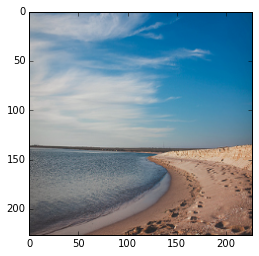

In [10]:
batch_index = 8
image = style_data_batch[batch_index]
orig_net.blobs['data'].data[0, ...] = image
probs = orig_net.forward()['probs'][0]
k = 5
top_k = (-probs).argsort()[:k]
print 'top %d predicted ImageNet labels =' % k
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], imagenet_labels[p])
                for i, p in enumerate(top_k))
plt.imshow(deprocess_net_image(image))

If we tried to look at `style_solver.net`'s predictions, we wouldn't see anything useful as its classifier been trained yet.  (The line below should output `True`, indicating the net's predictions from its classifier layer, `fc8_flickr`, are all zeroes.)

In [11]:
np.all(style_solver.net.blobs['fc8_flickr'].data == 0)

True

Now we'll invoke the solver to train the style net's classification layer.

For the record, if you want to train the network using only the command line tool, this is the command:

<code>
build/tools/caffe train \
    -solver models/finetune_flickr_style/solver.prototxt \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0
</code>

However, we will train using Python in this example.

In [12]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({s: np.zeros(niter) for _, s in solvers} for _ in blobs)
    for it in range(niter):
        for _, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[s][it], acc[s][it] = (s.net.blobs[b].data.copy()
                                       for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (name, loss[s][it], np.round(100*acc[s][it]))
                                  for name, s in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = []
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights.append(os.path.join(weight_dir, filename))
        s.net.save(weights[-1])
    return (loss, acc), weights

In [13]:
niter = 200  # number of iterations to train

# Reset style_solver as before.
style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_style_solver_filename = solver(style_net(train=True))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', style_solver),
           ('scratch', scratch_style_solver)]
metrics, trained_weights = run_solvers(niter, solvers)
print 'Done.'

loss, acc = metrics
train_loss, scratch_train_loss = loss[style_solver], loss[scratch_style_solver]
style_weights, scratch_style_weights = trained_weights

# Delete solvers to save memory.
del style_solver, scratch_style_solver

Running solvers for 200 iterations...
  0) pretrained: loss=2.996, acc= 0%; scratch: loss=2.996, acc= 0%
 10) pretrained: loss=1.315, acc=48%; scratch: loss=2.701, acc=14%
 20) pretrained: loss=1.120, acc=52%; scratch: loss=2.290, acc=12%
 30) pretrained: loss=0.940, acc=60%; scratch: loss=1.984, acc=22%
 40) pretrained: loss=0.875, acc=62%; scratch: loss=1.810, acc=24%
 50) pretrained: loss=1.077, acc=56%; scratch: loss=1.773, acc=32%
 60) pretrained: loss=0.918, acc=60%; scratch: loss=1.753, acc=16%
 70) pretrained: loss=0.952, acc=64%; scratch: loss=1.692, acc=30%
 80) pretrained: loss=0.969, acc=68%; scratch: loss=1.681, acc=34%
 90) pretrained: loss=1.105, acc=52%; scratch: loss=1.681, acc=24%
100) pretrained: loss=1.045, acc=60%; scratch: loss=1.654, acc=30%
110) pretrained: loss=0.815, acc=66%; scratch: loss=1.654, acc=30%
120) pretrained: loss=0.983, acc=62%; scratch: loss=1.652, acc=26%
130) pretrained: loss=1.243, acc=44%; scratch: loss=1.638, acc=28%
140) pretrained: loss=1.

Let's look at the training loss produced by the two training procedures respectively.  Notice how quickly the ImageNet pretrained model's loss value (blue) drops below the *final* loss value of the randomly initialized model (green).

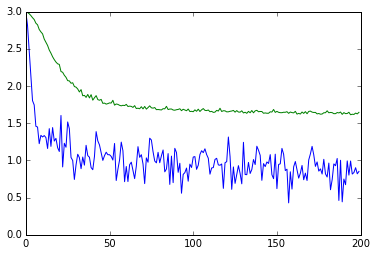

In [14]:
plot(np.vstack([train_loss, scratch_train_loss]).T)

Let's take a look at the testing accuracy after running 200 iterations of training. Note that we're classifying among 20 classes, giving chance accuracy of 5%. We expect the result from training using the ImageNet pretraining initialization to be much better than the one from training from scratch. Let's see.

In [15]:
def eval_style_net(weights, test_iters=10):
    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [16]:
test_net, accuracy = eval_style_net(style_weights)
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights)
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, trained from ImageNet initialization: 48.4%
Accuracy, trained from   random initialization: 23.6%


Finally, we'll train both nets again, starting from the weights we just learned.  The only difference this time is that we'll be learning the weights "end-to-end" by turning on learning in *all* layers of the network, starting from the RGB `conv1` filters directly applied to the input image.  We pass the argument `learn_all=True` to the `style_net` function defined earlier in this notebook, which tells the function to apply a positive (non-zero) `lr_mult` value for all parameters.  Under the default, learn_all=False, all parameters in the pretrained layers (`conv1` through `fc7`) are frozen (`lr_mult = 0`), and we learn only the classifier layer `fc8_flickr`.

Note that both networks start at roughly the accuracy achieved at the end of the previous training session, and improve significantly with end-to-end training.  To be more scientific, we'd also want to follow the same additional training procedure *without* the end-to-end training, to ensure that our results aren't better simply because we trained for twice as long.  Feel free to try this yourself!

In [17]:
end_to_end_net = style_net(train=True, learn_all=True)

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 0.001

style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(style_weights)

scratch_style_solver_filename = solver(end_to_end_net, base_lr=base_lr)
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)
scratch_style_solver.net.copy_from(scratch_style_weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained, end-to-end', style_solver),
           ('scratch, end-to-end', scratch_style_solver)]
_, finetuned_weights = run_solvers(niter, solvers)
print 'Done.'

style_weights_ft, scratch_style_weights_ft = finetuned_weights

# Delete solvers to save memory.
del style_solver, scratch_style_solver

Running solvers for 200 iterations...
  0) pretrained, end-to-end: loss=0.852, acc=64%; scratch, end-to-end: loss=1.616, acc=28%
 10) pretrained, end-to-end: loss=1.095, acc=62%; scratch, end-to-end: loss=1.663, acc=14%
 20) pretrained, end-to-end: loss=0.741, acc=70%; scratch, end-to-end: loss=1.651, acc=12%
 30) pretrained, end-to-end: loss=0.892, acc=76%; scratch, end-to-end: loss=1.594, acc=20%
 40) pretrained, end-to-end: loss=0.748, acc=68%; scratch, end-to-end: loss=1.576, acc=22%
 50) pretrained, end-to-end: loss=0.849, acc=68%; scratch, end-to-end: loss=1.604, acc=30%
 60) pretrained, end-to-end: loss=0.843, acc=64%; scratch, end-to-end: loss=1.474, acc=40%
 70) pretrained, end-to-end: loss=0.587, acc=74%; scratch, end-to-end: loss=1.490, acc=30%
 80) pretrained, end-to-end: loss=0.498, acc=78%; scratch, end-to-end: loss=1.398, acc=44%
 90) pretrained, end-to-end: loss=0.810, acc=68%; scratch, end-to-end: loss=1.490, acc=34%
100) pretrained, end-to-end: loss=0.791, acc=70%; sc

Let's now test the end-to-end finetuned models.  Since all layers have been optimized for the style recognition task at hand, we expect both nets to get better results than the ones above, which were achieved by nets with only their classifier layers trained for the style task (on top of either ImageNet pretrained or randomly initialized weights).

In [18]:
test_net, accuracy = eval_style_net(style_weights_ft)
print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights_ft)
print 'Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, finetuned from ImageNet initialization: 55.0%
Accuracy, finetuned from   random initialization: 40.6%


Finally, let's look at our style model's predictions for an image.

We'll first get set up by running `test_net.forward()` to make sure a batch of data is loaded into the net, and then reading the list of style labels from `style_names.txt`.

In [19]:
test_net.forward()
with open('examples/finetune_flickr_style/style_names.txt', 'r') as f:
    style_labels = [l.strip() for l in f.readlines()]
print 'Labels:', ', '.join(style_labels)

Labels: Detailed, Pastel, Melancholy, Noir, HDR, Vintage, Long Exposure, Horror, Sunny, Bright, Hazy, Bokeh, Serene, Texture, Ethereal, Macro, Depth of Field, Geometric Composition, Minimal, Romantic


actual label = Pastel
top 5 predicted style labels =
	(1) 76.31% Pastel
	(2) 13.16% Detailed
	(3)  7.38% Melancholy
	(4)  2.29% HDR
	(5)  0.41% Noir


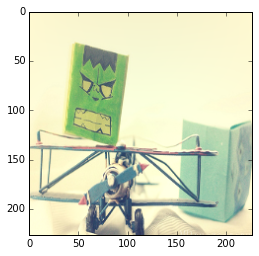

In [20]:
batch_index = 15
image = test_net.blobs['data'].data[batch_index]
probs = test_net.blobs['probs'].data[batch_index]
k = 5
top_k = (-probs).argsort()[:k]
print 'actual label =', style_labels[int(test_net.blobs['label'].data[batch_index])]
print 'top %d predicted style labels =' % k
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], style_labels[p])
                for i, p in enumerate(top_k))
plt.imshow(deprocess_net_image(image))

Of course, we can again look at the ImageNet model's predictions for the above image:

In [21]:
orig_net.blobs['data'].data[0, ...] = image
probs = orig_net.forward()['probs'][0]
k = 5
top_k = (-probs).argsort()[:k]
print 'top %d predicted ImageNet labels =' % k
print '\n'.join('\t(%d) %5.2f%% %s' % (i + 1, 100 * probs[p], imagenet_labels[p])
                for i, p in enumerate(top_k))

top 5 predicted ImageNet labels =
	(1) 38.11% n02840245 binder, ring-binder
	(2) 12.11% n03857828 oscilloscope, scope, cathode-ray oscilloscope, CRO
	(3)  8.52% n03291819 envelope
	(4)  5.49% n03794056 mousetrap
	(5)  5.23% n03666591 lighter, light, igniter, ignitor


Huzzah! So we did finetuning and it is awesome. Let's take a look at what kind of results we are able to get with a longer, more complete run of the style recognition dataset. Note: the below URL might be occassionally down because it is run on a research machine.

http://demo.vislab.berkeleyvision.org/